In [210]:
import numpy as np
import cv2 as cv
import matplotlib.path as mpltPath
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from haversine import inverse_haversine, Unit

%matplotlib inline


In [3]:
cameraH = np.array([[ 9.42118957e-01,  4.18822851e-01, -7.25736750e+01],
       [-3.63139244e-01,  9.57252119e-01,  1.40435108e+02],
       [ 8.82977443e-05,  1.30033207e-04,  1.00000000e+00]])

translation_vector = np.array([ 61.09920255, -16.,   0.])

In [32]:
#note: different resolutions have different coordinate systems...

#timestamp location for 1280x960
mask_points_time1 = np.array([[587.5, 19.8],
                             [587.5, 32.2],
                             [689.8, 32.2],
                             [689.8, 19.8]])

#timestamp location for 640x480
mask_points_time3 = np.array([[267, 32],
                             [267, 20],
                             [372, 20],
                             [372, 32],
                             [272, 32]])

#mask for buildings for camera 1, 1280x960 --> need to divde coordinates by 2 to get the 640x480 coordinates
img1_mask = np.array([[  2.78 , 869.98],
                             [ 3.40, 863.84],
                             [ 5.93, 863.07],
                             [ 6.7, 855.32],
                             [ 7.77,854.01],
                             [ 16.60, 853.17],
                             [ 41.55, 815.55],
                             [ 54.83, 805.65],
                             [ 56.14, 822.31],
                             [ 58.44, 840.66],
                             [ 64.28, 881.04],
                             [ 67.65, 881.81],
                             [ 73.18, 875.2],
                             [ 75.1 , 889.17],
                             [ 79.55 , 890.94],
                             [ 81.01, 894.47],
                             [90.38, 895.24],
                             [ 91.76, 907.29],
                             [96.44, 907.52 ],
                             [102.28, 899.62],
                             [110.18, 881.34],
                             [111.8, 882.8 ],
                             [115.17, 906.45],
                             [167.92, 906.68],
                             [179.92, 907.29],
                             [181.43, 902.61],
                             [185.03, 904.38],
                             [185.11, 910.36],
                             [191.64, 910.44 ],
                             [206.61, 889.41],
                             [214.74, 889.94],
                             [231.8, 908.2],
                             [246.5, 906.2],
                             [317.7, 906.4],
                             [319 , 879.3],
                             [328.9, 879.3],
                             [331.5 , 875.2],
                             [339.2 , 873.9],
                             [342.0, 862.4],
                             [355.6, 882.3],
                             [354.1, 912.3],
                             [376.4, 911.9 ],
                             [379.2, 902],
                             [392.1, 903.7],
                             [392.1, 909.2],
                             [415.2, 910.3],
                             [415.9, 918.7],
                             [469.2, 917.4],
                             [470.5, 912.1],
                             [476.5, 911.6],
                             [482.8, 779],
                             [893.2, 779],
                             [910.0, 938.5],
                             [1022.9, 939.0],
                             [1025.2, 952.8],
                             [1055.4, 952.8],
                             [1052.9, 929.3],
                             [1054.8, 929.3],
                             [1059.3, 956.1],
                             [1093.7, 955.9],
                             [1112.1, 957.8],
                             [1119.1, 941.2],
                             [1119.8, 916.2],
                             [1123.8, 916.8],
                             [1143.7, 956.9],
                             [1156.7, 958.2],
                             [1093.3, 624.8],
                             [1130.8, 551.1],
                             [1125.0, 518.1],
                             [1128.2, 478.4],
                             [1154.5, 526],
                             [1161.8, 551.1],
                             [1202.9, 587.3],
                             [1225.0, 593.7],
                             [1276.8, 801.0]])

#use this for the low res image (640x480) (i think)
img1_mask_lowres = img1_mask/2

#mask for buildings for camera 3 
img3_mask = np.array([[  0.0001 , 431.9],
                             [ 7.78, 397.65],
                             [ 15.16, 399.28],
                             [ 6.05, 445.8],
                             [ 27.63,448.1],
                             [ 28.01, 452.52],
                             [ 33.39, 452.99],
                             [ 34.73, 450.11],
                             [ 69.93, 451.65],
                             [ 71.18, 458.27],
                             [ 75.78, 457.31],
                             [ 76.74, 453.53],
                             [ 83.93, 453.47],
                             [ 84.32 , 457.12],
                             [ 89.11 , 457.6],
                             [ 90.07, 452.71],
                             [97.94, 453.09],
                             [ 98.23, 457.02],
                             [101.49, 456.45 ],
                             [101.49, 451.17],
                             [112.23, 452.62],
                             [114.92, 466.04 ],
                             [124.32, 449.93],
                             [124.70, 459.91],
                             [153.76, 459.52],
                             [154.82, 450.02],
                             [155.39, 451.46],
                             [162.2, 462.97],
                             [174.58, 436.5 ],
                             [176.88, 424.79],
                             [186.18, 424.41],
                             [190.21, 452.52],
                             [192.42, 434.29],
                             [196.25, 434.67],
                             [197.12 ,426.71],
                             [214.86, 427.29],
                             [215.63 , 451.17],
                             [220.23 , 439.28],
                             [226.66, 439.37],
                             [230.88, 460.38],
                             [240.66, 460.19],
                             [243.16, 454.53 ],
                             [251.89, 454.15],
                             [256.87, 446.57],
                             [263.97, 454.43],
                             [264.64, 462.68],
                             [268.1, 462.97],
                             [269.44, 456.45],
                             [278.65, 462.78],
                             [278.84, 459.33],
                             [281.24, 457.85],
                             [296.88, 457.6],
                             [296.1, 462.78],
                             [311.07, 463.55],
                             [313.27, 459.9],
                             [341.67, 460.57],
                             [342.34, 447.82],
                             [346.56, 447.91],
                             [346.37, 462.3],
                             [369.0, 460.76],
                             [368.81, 455.1],
                             [375.62, 455.01],
                             [375.81, 462.30],
                             [395.09, 462.11],
                             [395.0, 449],
                             [399.6, 449.35],
                             [399.5, 460.8],
                             [413.03, 462.3],
                             [412.16, 445.61],
                             [416.0, 444.07],
                             [415.04, 426.91],
                             [425.21, 426.04],
                             [427.13, 432.95],
                             [425.21, 426.04],
                             [427.13, 432.37],
                             [430.96, 426.04],
                             [433.46, 432.37],
                             [439.12,431.99],
                             [438.45, 399.95],
                             [443.05, 400.72],
                             [444.58, 430.93],
                             [555.56, 434.1],
                             [556.62, 437.94],
                             [567.74, 437.07],
                             [580.02, 430.26],
                             [599.88,429.40],
                             [604.19, 437.17],
                             [612.44, 437.46],
                             [613.3, 430.74],
                             [612.46, 432.76],
                             [622.03, 438.42],
                             [628.84, 438.61],
                             [636.04, 470.84],
                             [639.3, 470.55]])


def gen_mask(points, imshape, timemask=None):
    # make blank mask
    ind_y, ind_x = np.meshgrid(np.arange(0.5, imshape[1]),
                               np.arange(0.5, imshape[0]))
    # Ensure the points go to the edge of the image
    newpoints = [[641, points[-1, 1]],
                 [641, -1],
                 [-1, -1],
                 [-1, points[0, 1]],
                 [points[0, 0], points[0, 1]]]
    points = np.concatenate((points, newpoints), axis=0)
    points_poly = mpltPath.Path(points)
    mask = points_poly.contains_points(np.array(list(zip(ind_x.ravel(), ind_y.ravel())))).reshape(imshape)

    if timemask is not None:
        points_poly = mpltPath.Path(timemask)
        tmask = points_poly.contains_points(np.array(list(zip(ind_x.ravel(), ind_y.ravel())))).reshape(imshape)
        mask = mask & ~tmask
        
    return mask.transpose()[:, :, None].astype('uint8')

mask_C1 = gen_mask(img1_mask_lowres, (640, 480), timemask=mask_points_time3)
mask_C3 = gen_mask(img3_mask, (640, 480), timemask=mask_points_time3)

In [33]:
%cd "C:\Users\kathe\OneDrive - Imperial College London\MSci Project\matrices"
fundamental_matrix = np.loadtxt(r'fundamental_matrix.csv', delimiter = ',')
essential_matrix = np.loadtxt(r'essential_matrix.csv', delimiter = ',')
pose = np.loadtxt(r'pose[1].csv', delimiter = ',')
T = np.loadtxt(r'T.csv', delimiter = ',')
Rleft = np.loadtxt(r'Rleft.csv', delimiter = ',')
Rright = np.loadtxt(r'Rright.csv', delimiter = ',')
Pleft = np.loadtxt(r'Pleft.csv', delimiter = ',')
Pright = np.loadtxt(r'Pright.csv', delimiter = ',')
Q = np.loadtxt(r'Q.csv', delimiter = ',')
Hleft = np.loadtxt(r'Hleft.csv', delimiter = ',')
Hright = np.loadtxt(r'Hright.csv', delimiter = ',')
roi_left = np.loadtxt(r'roi_left.csv', delimiter = ',')
roi_right = np.loadtxt(r'roi_right.csv', delimiter = ',')

C:\Users\kathe\OneDrive - Imperial College London\MSci Project\matrices


C:\Users\kathe\OneDrive - Imperial College London\MSci Project


C:\Users\kathe\AppData\Local\Temp/ipykernel_7104/197555745.py:154: RuntimeWarning: invalid value encountered in true_divide
  rg_ratio1 = rimgR[:, :, 1]/rimgR[:, :, 2]
C:\Users\kathe\AppData\Local\Temp/ipykernel_7104/197555745.py:157: RuntimeWarning: invalid value encountered in true_divide
  rg_ratio3 = rimgL[:, :, 1]/rimgL[:, :, 2]


frame number 205


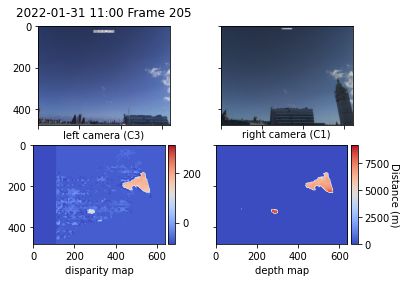

In [186]:
%cd "C:\Users\kathe\OneDrive - Imperial College London\MSci Project\"
#camera matrices and distortion for the 640x480 resolution
#i am using the 640x480v2 values for both cameras because camera3 doesn't have its own
CamM_left = np.array([[5.520688775958645920e+02,0.000000000000000000e+00,3.225866125962970159e+02],
          [0.000000000000000000e+00,5.502640890663026312e+02,2.362389385357402034e+02],
          [0.000000000000000000e+00,0.000000000000000000e+00,1.000000000000000000e+00]])

CamM_right = np.array([[5.520688775958645920e+02,0.000000000000000000e+00,3.225866125962970159e+02],
          [0.000000000000000000e+00,5.502640890663026312e+02,2.362389385357402034e+02],
          [0.000000000000000000e+00,0.000000000000000000e+00,1.000000000000000000e+00]])


Distort_left = np.array([2.808374038768443048e-01,-9.909134707088265159e-01,6.299531255281858727e-04,-1.301770463801651002e-03,1.093982545460403522e+00])
Distort_right = np.array([2.808374038768443048e-01,-9.909134707088265159e-01,6.299531255281858727e-04,-1.301770463801651002e-03,1.093982545460403522e+00])

w, h = 640, 480

#Create stereo matching object and set disparity parameters
#Note: disparity range is tuned according to specific parameters obtained through trial and error.
#win_size = 5
#min_disp = 0
#max_disp = 64
#num_disp = max_disp - min_disp # Needs to be divisible by 16
#Create Block matching object.
#stereo = cv.StereoSGBM_create(minDisparity= min_disp,
# numDisparities = num_disp,
# blockSize = 5,
# uniquenessRatio = 15,
# speckleWindowSize = 100,
# speckleRange = 2,
# disp12MaxDiff = 15,
# P1 = 8*3*win_size**2,#8*3*win_size**2,
# P2 =32*3*win_size**2) #32*3*win_size**2

#Create stereo matching object and set disparity parameters
#Note: disparity range is tuned according to specific parameters obtained through trial and error.
win_size = 8
min_disp = 0
max_disp = 7
num_disp = 16*max_disp - 16*min_disp # Needs to be divisible by 16
#Create Block matching object.
stereo = cv.StereoSGBM_create(minDisparity=min_disp,
 numDisparities = num_disp,
 blockSize = 9,
 uniquenessRatio = 13,
 speckleWindowSize = 5,
 speckleRange = 14,
 disp12MaxDiff = 7,
 P1 = 8*3*win_size**2,
 P2 =32*3*win_size**2) 

#prefix_right = 'C1'
#prefix_left = 'C3'
prefix_right = 'tl'
prefix_left = 'tl4'
vidfolder = "C:/Users/kathe/OneDrive - Imperial College London/MSci Project/Videos/"
dtime = '2022-01-31'
hour = 11
frame_no = 204
vidcapR = cv.VideoCapture(f'{vidfolder}/{prefix_right}_{dtime}_{hour:0>2}A.mp4')
vidcapL = cv.VideoCapture(f'{vidfolder}/{prefix_left}_{dtime}_{hour:0>2}A.mp4')

# Check if camera opened successfully
if vidcapR.isOpened()== False:
    print("Error opening right camera")
if vidcapL.isOpened()== False:
    print("Error opening left camera")

vidcapR.set(cv.CAP_PROP_POS_FRAMES,frame_no) # Where frame_no is the frame you want
vidcapL.set(cv.CAP_PROP_POS_FRAMES,frame_no)
successR, imgRLarge = vidcapR.read() # Read the frame
#success, imgR = vidcapR.read()
successL, imgL = vidcapL.read()
if successR==True and successL == True:
    imgL = cv.cvtColor(imgL, cv.COLOR_BGR2RGB)
    imgR = cv.resize(imgRLarge,(640,480),fx=0,fy=0, interpolation = cv.INTER_CUBIC)
    imgR = cv.cvtColor(imgR, cv.COLOR_BGR2RGB)
    vidcapR.release()
    vidcapL.release()

# folder = "C:/Users/kathe/OneDrive - Imperial College London/MSci Project/longExposures/"
# imgRLarge = cv.imread(folder+'tl_2021-10-30_230002_CAL1.jpg')
# imgLLarge = cv.imread(folder+'tl4_2021-10-30_230002_CAL1.jpg')
# imgR = cv.resize(imgRLarge,(640,480),fx=0,fy=0, interpolation = cv.INTER_CUBIC)
# imgL = cv.resize(imgLLarge,(640,480),fx=0,fy=0, interpolation = cv.INTER_CUBIC)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, sharex=True, sharey=True)
ax1.imshow(imgL)
ax1.set_xlabel('left camera (C3)')
ax1.set_title(f'{dtime} {hour}:00 Frame {frame_no+1}', pad=10)
ax2.imshow(imgR)
ax2.set_xlabel('right camera (C1)')

#assume both images have same height and width

new_camera_matrixleft, roi = cv.getOptimalNewCameraMatrix(CamM_left,Distort_left,(w,h),1,(w,h))
new_camera_matrixright, roi = cv.getOptimalNewCameraMatrix(CamM_right,Distort_right,(w,h),1,(w,h))

#Undistort images
imgR_undistorted = cv.undistort(imgR, CamM_right, Distort_right, None, new_camera_matrixright)
imgL_undistorted = cv.undistort(imgL, CamM_left, Distort_left, None, new_camera_matrixleft)

#creates new map for each camera with the rotation and pose (R and P) values
mapLx, mapLy = cv.initUndistortRectifyMap(new_camera_matrixleft, Distort_left, Rleft, Pleft, (w,h), cv.CV_32FC1)
mapRx, mapRy = cv.initUndistortRectifyMap(new_camera_matrixright, Distort_right, Rright, Pright, (w,h), cv.CV_32FC1)

# remaps each image to the new map
rimgR = cv.remap(imgR, mapRx, mapRy,
                      interpolation=cv.INTER_NEAREST,
                      borderMode=cv.BORDER_CONSTANT,
                      borderValue=(0, 0, 0, 0))
rimgL = cv.remap(imgL, mapLx, mapLy,
                      interpolation=cv.INTER_NEAREST,
                      borderMode=cv.BORDER_CONSTANT,
                      borderValue=(0, 0, 0, 0))

rect_mask_C3 = cv.remap(mask_C3[:,:,0], mapLx, mapLy,
                            interpolation=cv.INTER_NEAREST,
                            borderMode=cv.BORDER_CONSTANT,
                            borderValue=(0, 0, 0, 0))

rect_mask_C1 = cv.remap(mask_C1[:,:,0], mapRx, mapRy,
                            interpolation=cv.INTER_NEAREST,
                            borderMode=cv.BORDER_CONSTANT,
                            borderValue=(0, 0, 0, 0))

rect_mask = rect_mask_C1 & rect_mask_C3

rimgL = cv.bitwise_and(rimgL, rimgL, mask=rect_mask)
rimgR = cv.bitwise_and(rimgR, rimgR, mask=rect_mask)


# compute disparity map for the rectified images
disparity_map = stereo.compute(rimgL, rimgR).astype(np.float32) - 70



im3d = cv.reprojectImageTo3D((disparity_map)/32, Q, handleMissingValues = True)
im3d[im3d == np.inf] = 0
im3d[im3d > 9_000] = 0
im3d[im3d < -9000] = 0
im3d[im3d == -np.inf] = 0
im3d[im3d[:,:,2] == 0] = 0
im3d[im3d[:,:,1] == 0] = 0
im3d[im3d[:,:,0] == 0] = 0


depths = np.sqrt(im3d[:,:,0]**2 + im3d[:,:,1]**2 + im3d[:,:,2]**2)
stereo_x = im3d[:,:,0]
stereo_y = im3d[:,:,1]
stereo_z = im3d[:,:,2]

### uncomment if you want to mask out sky ###
rg_ratio1 = rimgR[:, :, 1]/rimgR[:, :, 2]
skymask_C1 =  mask_C1[:,:,0] & (rg_ratio1<1.1) & (rg_ratio1>0.93)

rg_ratio3 = rimgL[:, :, 1]/rimgL[:, :, 2]
skymask_C3 =  mask_C3[:,:,0] & (rg_ratio1<1.1) & (rg_ratio1>0.93)
#depths_skymask = cv.bitwise_and(depths, depths, mask=skymask_C1)

#combine mask1 and mask3 and rectify 
disp_mask = cv.remap(skymask_C3, mapLx, mapLy,
                            interpolation=cv.INTER_NEAREST,
                            borderMode=cv.BORDER_CONSTANT,
                            borderValue=(0, 0, 0, 0))

#depths = cv.bitwise_and(depths, depths, mask=disp_mask)

disp = ax3.imshow(disparity_map,'coolwarm')
ax3.set_xlabel('disparity map')
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(disp, cax=cax, orientation='vertical')
#cbar.set_label('Disparity', rotation=270, labelpad=6)

depth = ax4.imshow(depths, 'coolwarm')
ax4.set_xlabel('depth map')
divider2 = make_axes_locatable(ax4)
cax2 = divider2.append_axes('right', size='5%', pad=0.05)
cbar2 = fig.colorbar(depth, cax=cax2, orientation='vertical')
cbar2.set_label('Distance (m)', rotation=270, labelpad=10)
# plt.savefig(f'{dtime}_{hour}_frame_{frame_no+1}_disp_buildingMaskNoZeros.png', bbox_inches='tight')
print('frame number', frame_no+1)
    
    







In [187]:
import cameratransform as ct
# Our origin is at camera 3 so we want all the parameters for this camera

# intrinsic camera parameters
f_mm = 3.04    # in mm
pixel_size = 1.12e-3 # length of one side of square pixel in mm
sensor_size = (3.68, 2.76) # in mm
image_size = (w,h)    # in px
f_x_px = (f_mm /sensor_size[0]) * image_size[0] #focal length relative to pixel width
f_y_px = (f_mm /sensor_size[1]) * image_size[1] #focallength relative to pixel height

camera = ct.Camera(ct.RectilinearProjection(focallength_x_px = f_x_px, focallength_y_px = f_y_px, image = rimgL))
camera.setGPSpos(51.4993318750954, -0.17901837289811393, 46)
#using values calculated for camera 3 using cameratransform
camera.elevation_m = 45.331277  
camera.tilt_deg = 113.702596 
camera.heading_deg = 82.665769
camera.roll_deg = -1.204690        #110.847355    90.425038 -19.934881

In [288]:
L = np.array([[0,1,0],
              [0,0,1],
              [1,0,0]])

h = 82.665769
t = 113.702596 - 90
r =-1.204690

R = np.array([[np.cos(h)*np.cos(r) - np.sin(h)*np.sin(t)*np.sin(r), 
                                    -np.sin(h)*np.cos(t), 
                                    np.cos(h)*np.cos(r) + np.sin(h)*np.sin(t)*np.sin(r)],

                [np.sin(h)*np.cos(r)-np.cos(h)*np.sin(t)*np.sin(r), 
                                    np.cos(h)*np.cos(t), 
                                    np.sin(h)*np.sin(r)-np.cos(h)*np.sin(t)*np.cos(r)],

                [-np.cos(t)*np.sin(r), np.sin(t), np.cos(t)*np.cos(r)]])


roll_rot = np.array([[np.cos(r), 0, np.sin(r)],
                    [0,          1,         0],
                    [-np.sin(r), 0, np.cos(r)]])

heading_rot = np.array([[np.cos(h), -np.sin(h), 0],
                        [np.sin(h), np.cos(h),  0],
                        [0,         0,          1]])

tilt_rot = np.array([[1,        0,         0],
                    [0, np.cos(t), -np.sin(t)],
                    [0, np.sin(t), np.cos(t)]])


def cam2world(cam, l, r):
    l_inv = np.linalg.inv(l)
    r_inv = np.linalg.inv(r)
    flip = np.matmul(l_inv, cam)
    return np.matmul(r_inv, flip)


def cam2worldv2(cam, head=heading_rot, tilt=tilt_rot, roll=roll_rot, l=L):
    head_inv = np.linalg.inv(head)
    tilt_inv = np.linalg.inv(tilt)
    roll_inv = np.linalg.inv(roll)
    l_inv = np.linalg.inv(l)
    rot = np.matmul(roll, tilt, head)
    flip = np.matmul(l, cam)
    return np.matmul(rot, flip)
   




def world2gps(x, y, origin=(51.4993318750954, -0.17901837289811393)):
    dist = np.sqrt(x**2 + y**2)
    angle = np.arctan(y/x)
    return inverse_haversine(origin, dist, angle, unit=Unit.METERS)



In [289]:
depth_x = []
depth_y = []
depth_val = []
space_coords = []
world_coords = []
heights = []
for j in range (0,480):
    for i in range (0,640):
        if 0 < depths[j,i] < 50000:
            if stereo_z[j,i] != 0:
                depth_val.append(depths[j,i])
                depth_x.append(i)
                depth_y.append(j)
                elev = np.arccos(stereo_z[j,i]/depths[j,i])
                tilt = (np.pi/180) * (camera.tilt_deg - 90)
                world_coord = cam2worldv2(np.array([stereo_x[j,i], stereo_y[j,i], stereo_z[j,i]]))
                gps = world2gps(world_coord[0], world_coord[1])
                height = stereo_z[j,i] * np.tan(tilt + elev) + 46
                heights.append(height)
                world_coords.append(gps)    
                space_coord = camera.spaceFromImage([i,j], Z=depths[j,i])
                space_coords.append(np.array(space_coord))
        
depth_x = np.array(depth_x)
depth_y = np.array(depth_y)  
depth_val = np.array(depth_val)
space_coords = np.array(space_coords)
world_coords = np.array(world_coords)
heights = np.array(heights)

print(world_coords.shape)

(6792, 2)


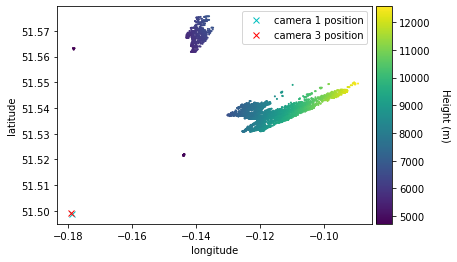

In [290]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
world = ax.scatter(world_coords[:,1], world_coords[:,0], 1, heights)
ax.plot(-0.1788492157810761, 51.49880908055068, 'cx', label='camera 1 position')
ax.plot(-0.17901837289811393, 51.4993318750954, 'rx', label='camera 3 position')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(world, cax=cax, orientation='vertical')
cbar.set_label('Height (m)', rotation=270, labelpad=20)
ax.legend()
#plt.savefig(f'{dtime}_{hour}_frame_{frame_no+1}_world.png', bbox_inches='tight')


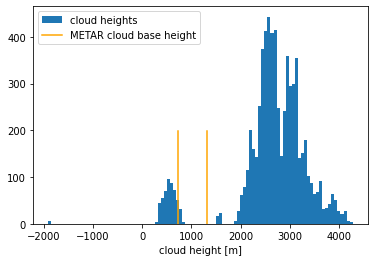

In [244]:
fig, ax = plt.subplots(1,1)
ax.hist(heights, bins=100, label='cloud heights')
y = np.arange(0,200,1)
x = np.ones(200)
ax.plot(720*x, y, color='orange', label='METAR cloud base height')
ax.plot(1320*x, y, color='orange')
ax.set_xlabel('cloud height [m]')
ax.legend()
#plt.savefig(f'{dtime}_{hour}_frame_{frame_no+1}_heights_histogram.png', bbox_inches = 'tight')


In [12]:
# Upper Left  (  600000.000, 5800020.000) (  1d31'55.62"W, 52d20'28.88"N)
# Lower Left  (  600000.000, 5690220.000) (  1d33'49.97"W, 51d21'15.98"N)
# Upper Right (  709800.000, 5800020.000) (  0d 4'39.93"E, 52d18'37.32"N)
# Lower Right (  709800.000, 5690220.000) (  0d 0'40.51"E, 51d19'28.28"N)


print(transform.TransformPoint(600000.000, 5800020.000))
print(transform.TransformPoint(600000.000, 5690220.000))
print(transform.TransformPoint(709800.000, 5800020.000))
print(transform.TransformPoint(709800.000, 5690220.000))
print(gt)
im.shape

NameError: name 'transform' is not defined

Text(0.5, 0, 'longitude')

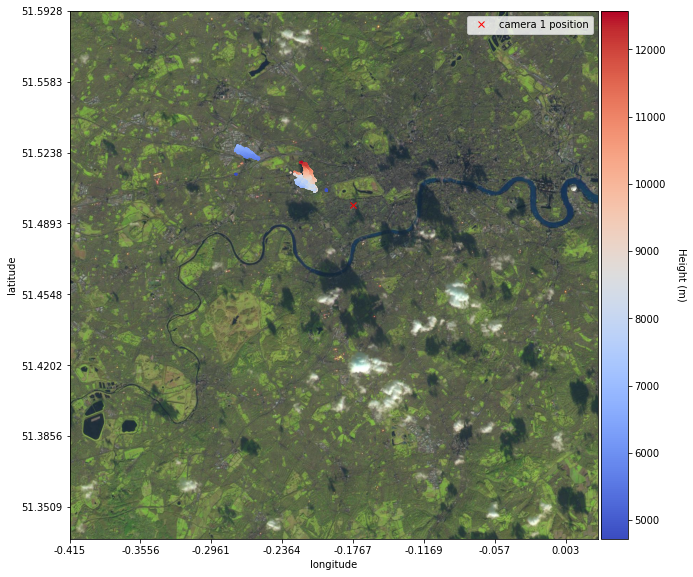

In [260]:
from osgeo import gdal, osr
from matplotlib.ticker import StrMethodFormatter
import matplotlib.pyplot as plt
import numpy as np

ds = gdal.Open("C:/Users/kathe/OneDrive - Imperial College London/MSci Project/sentinel2A_20210928.tif")
old_cs= osr.SpatialReference()
old_cs.ImportFromWkt(ds.GetProjectionRef())

# create the new coordinate system
wgs84_wkt = """
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.01745329251994328,
        AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]]"""
new_cs = osr.SpatialReference()#
new_cs .ImportFromWkt(wgs84_wkt)

# create a transform object to convert between coordinate systems
transform = osr.CoordinateTransformation(old_cs,new_cs)

width = ds.RasterXSize
height = ds.RasterYSize
gt = ds.GetGeoTransform()
minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5] 
maxx = gt[0] + width*gt[1] + height*gt[2]
maxy = gt[3] 

def landsat_coords(i, j):
    x = gt[0] + i*gt[1] + j*gt[2]
    #y = gt[3] + (width-i)*gt[4] + (height-j)*gt[5]
    y = gt[3] + i*gt[4] + j*gt[5]
    return transform.TransformPoint(x, y)

# lat = []
# long = []
# #get the coordinates in lat long
# for i in range(int(minx),int(maxx), 20):
#     for j in range(int(miny), int(maxy), 20):
#         lat.append(transform.TransformPoint(i,j)[0])
#         long.append(transform.TransformPoint(i,j)[1])
# ##latlong = transform.TransformPoint(landsat_coords(0,0)[0], landsat_coords(0,0)[1])



px = np.arange(0,5490,1)
py = np.arange(0,5490,1)

oldx = np.array([4000,4200,4400,4600,4800,5000,5200,5400])
oldy = np.array([5400,5200,5000,4800,4600,4400,4200,4000])

gps = list(map(landsat_coords, px, py))
gps = np.array(gps)

new = list(map(landsat_coords, oldx, oldy))
new = np.array(new)
lat = new[:,0]
long = new[:,1]


im = plt.imread("C:/Users/kathe/OneDrive - Imperial College London/MSci Project/sentinel2B_20220131.tif")
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_xlim(4000,5490)
ax.set_ylim(5490,4000)
ax.imshow(im)
ax.set_xticks(oldx, np.round(long, 4))
ax.set_yticks(oldy, np.round(lat, 4))
world = ax.scatter(
    coord_to_pixel_x(world_coords[:,1]), 
    coord_to_pixel_y(world_coords[:,0]), 
    2, 
    heights, cmap='coolwarm')
# ax.plot(-0.1788492157810761, 51.49880908055068, 'cx', label='camera 1 position')
# ax.plot(-0.17901837289811393, 51.4993318750954, 'rx', label='camera 3 position')

c1x = coord_to_pixel_x(-0.1788492157810761)
c1y = coord_to_pixel_y(51.49880908055068)
ax.plot(c1x, c1y, 'rx', label='camera 1 position')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(world, cax=cax, orientation='vertical')
cbar.set_label('Height (m)', rotation=270, labelpad=20)
ax.legend()
ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
#plt.savefig('satellite20210928.png', bbox_inches='tight')


In [42]:
world_coords[:,1].shape

(23751,)

In [14]:
def coord_to_pixel_x(coord, min_coord=-1.563879374885302, max_coord=0.02, points=5490):
    return (coord - min_coord) / (max_coord - min_coord) * points
def coord_to_pixel_y(coord, min_coord=51.324523354307196, max_coord=52.34135509678961, points=5490):
    return points - (coord - min_coord) / (max_coord - min_coord) * points

In [7]:
!pip install cameratransform

  Using cached cameratransform-1.2-py3-none-any.whl (48 kB)
  Using cached tqdm-4.62.3-py2.py3-none-any.whl (76 kB)
  Using cached pytz-2021.3-py2.py3-none-any.whl (503 kB)


In [72]:
!gdalinfo "C:/Users/kathe/OneDrive - Imperial College London/MSci Project/sentinel2A_20210928.tif" 

Driver: GTiff/GeoTIFF
Files: C:/Users/kathe/OneDrive - Imperial College London/MSci Project/sentinel2A_20210928.tif
Size is 5490, 5490
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 30N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 30N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-3,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
      

In [209]:
!pip install haversine

  Using cached haversine-2.5.1-py2.py3-none-any.whl (6.1 kB)
